# Proyecto Est. Multivariada

In [1]:
#Acceder a Drive
#from google.colab import drive
#drive.mount('/content/drive')

## Importar librerías

In [ ]:
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Directorio de trabajo
#new_base_dir=r"/content/drive/MyDrive/human_detection_dataset"
new_base_dir=r"human_detection_dataset"

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución.

Ajustando los datos para que todas las imágenes tengan la misma resolución y se procesen en lotes de 32 por cada pasada del algoritmo descenso de gradiente

In [ ]:
#Importar datos
#batch_size 32
n_batch = 32
train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=n_batch)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=n_batch)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=n_batch)

Found 307 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


Visualizar el tensor asociado a los datos y las etiquetas

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Métricas a usar

Se usará Accuracy, Recall, Precision y F1-score

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Modelo VGG16 - Sin y Con Regularización - Sin Data Augmentation - Con Fine Tunning





---

Variando Dropout

Instanciando la red pre-entrenada VGG16 sin expansión de datos 

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


La fase de entrenamiento podrá alterar los pesos de las n últimas capas

In [ ]:
n_capas_alt = 4
conv_base.trainable = True
for layer in conv_base.layers[:-n_capas_alt]:
    layer.trainable = False

Resumen red VGG16

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Entrenar la red variando Dropout

10/10 [==============================] - 4s 137ms/step - loss: 0.6811 - accuracy: 0.8052 - f1_m: 0.8398 - precision_m: 0.8518 - recall_m: 0.8349


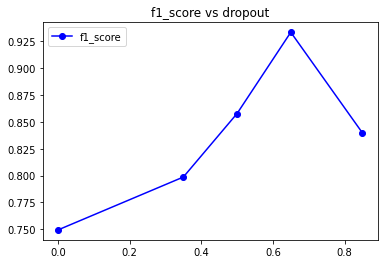

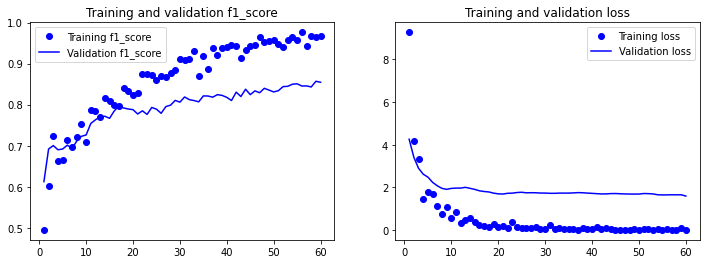

Mejores resultados: con 0.65 Dropout 
test_loss: 0.6388
test_accuracy: 0.9188
test_f1_score: 0.9335
test_precision: 0.9474
test_recall: 0.9219


In [ ]:
v_dropout = [0, 0.35, 0.5, 0.65, 0.85]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout
for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 4
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)

  
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento
  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])